colab version title => 시계열_기온예측

In [1]:
import os

fname = os.path.join('./data/jena_climate_2009_2016.csv')

with open(fname) as f:
  data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header) 
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
# 데이터 파싱

import numpy as np

temperature = np.zeros((len(lines), ))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

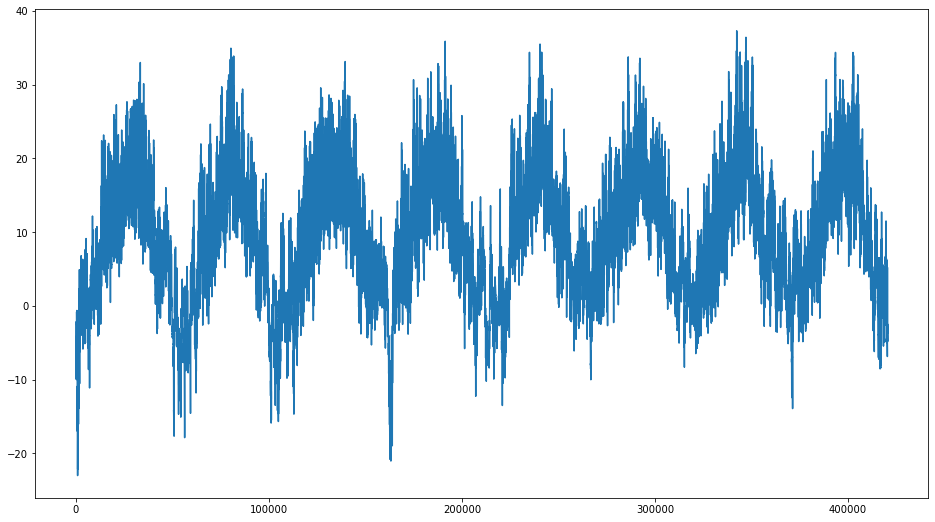

In [3]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16,9))
plt.plot(range(len(temperature)), temperature)
plt.show()

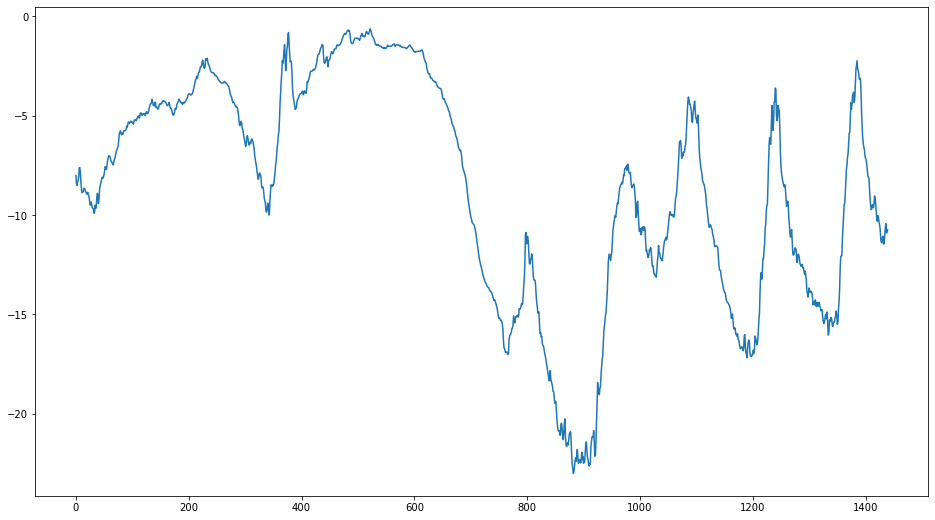

In [4]:
# 처음 10일 간의 기온을 그래프로 시각화하기

plt.figure(figsize=(16,9))
plt.plot(range(1440), temperature[:1440])
plt.show()

In [5]:
len(raw_data)

420451

In [7]:
# 각 분할에 사용할 샘플 수 계산

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [8]:
print(num_train_samples, num_val_samples, num_test_samples)

210225 105112 105114


In [9]:
# 데이터 정규화

mean = raw_data[:num_train_samples].mean(axis = 0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis = 0)
raw_data /= std

In [13]:
from tensorflow import keras

sampling_rate = 6  # 1시간을 10분 단위로
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples)

In [14]:
# 배치 크기 확인하기

for samples, targets in train_dataset:
  print(samples.shape, targets.shape)
  break

(256, 120, 14) (256,)


14 = 기온에 영향을 주는 lines의 column 개수

In [16]:
from tensorflow import keras
from tensorflow.keras import layers 

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1])) # shape = (시간 정보, multi_column)
x = layers.Flatten()(inputs)
x = layers.Dense(units=16, activation='relu')(x)
outputs = layers.Dense(units=1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_dense.keras', save_best_only=True)
]

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

In [17]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset,
                    callbacks = callbacks)

Epoch 1/10
819/819 [==============================] - 30s 36ms/step - loss: 12.3471 - mae: 2.7332 - val_loss: 11.8284 - val_mae: 2.7160
Epoch 2/10
819/819 [==============================] - 29s 35ms/step - loss: 9.2014 - mae: 2.3855 - val_loss: 10.2016 - val_mae: 2.5207
Epoch 3/10
819/819 [==============================] - 33s 40ms/step - loss: 8.3736 - mae: 2.2748 - val_loss: 10.3483 - val_mae: 2.5450
Epoch 4/10
819/819 [==============================] - 29s 35ms/step - loss: 7.9084 - mae: 2.2087 - val_loss: 10.2677 - val_mae: 2.5360
Epoch 5/10
819/819 [==============================] - 29s 35ms/step - loss: 7.6086 - mae: 2.1653 - val_loss: 10.3833 - val_mae: 2.5489
Epoch 6/10
819/819 [==============================] - 27s 33ms/step - loss: 7.3766 - mae: 2.1334 - val_loss: 12.5454 - val_mae: 2.8128
Epoch 7/10
819/819 [==============================] - 25s 31ms/step - loss: 7.1869 - mae: 2.1054 - val_loss: 10.9297 - val_mae: 2.6053
Epoch 8/10
819/819 [==============================] - 

In [28]:
model = keras.models.load_model('jena_dense.keras')
print(f'테스트 MAE : {model.evaluate(test_dataset)[1]:.2f}')

405/405 [==============================] - 11s 25ms/step - loss: 11.3813 - mae: 2.6456
테스트 MAE : 2.65


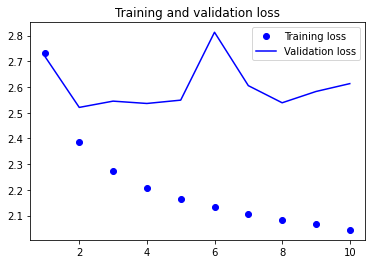

In [29]:
import matplotlib.pyplot as plt

loss = history.history['mae']
val_loss = history.history['val_mae']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
### 상식 수준의 기준점
# 검증 MAE 2.44
# 테스트 MAE 2.62

## timeseries_dataset_from_array() 이해하기(P.384)
targets는 약간의 시차를 두고 data 배열과 동일해야 합니다.  
예를 들어 data 가 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]이고 sequence_length=3인 경우, targets는 data와 배열이 같지만 약간의 시차를 둔 배열 [3, 4, 5, 6, ...]이다.  

Q. sequence_length 와 targets, data의 관계를 정확하게 정리하면? targets 값은 원하는 시간차에 따라 달라질 수 있다. 예를 들어 24시간 뒤, 30일 뒤 등 세우는 기준에 따라 달라지는 값이다.  sequence_length는 관측 범위 정도에 해당한다. 예를 들어 10일 간 관측한 값에 비해 target값만큼의 시간차를 둔 시점에 값을 구하는 것이다.  

참고 링크 : https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

# [과제 1] 1D 합성곱 모델 시도하기

# [과제 2] LSTM 기반 모델 시도하기

## 데이터 로드

In [74]:
import os

fname = os.path.join('./data/jena_climate_2009_2016.csv')

with open(fname) as f:
  data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header) 
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


## 데이터 파싱(numpy로 변환)

In [75]:
import numpy as np

temperature = np.zeros((len(lines), ))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

## 데이터 준비하기

In [76]:
# 각 분할에 사용할 샘플 수 계산
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [77]:
print(num_train_samples, num_val_samples, num_test_samples)

210225 105112 105114


In [78]:
# 데이터 정규화
mean = raw_data[:num_train_samples].mean(axis = 0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis = 0)
raw_data /= std

In [79]:
from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples)

In [80]:
# 배치 크기 확인하기
for samples, targets in train_dataset:
    print(samples.shape, targets.shape)
    break

(256, 120, 14) (256,)


## 모델 정의

In [81]:
from keras.models import Sequential
from keras import layers
from keras.layers import LSTM, Embedding, Dense
from tensorflow.keras import preprocessing
from keras.optimizers import RMSprop

In [82]:
model = Sequential()
model.add(layers.LSTM(units=32, input_shape=(None, raw_data.shape[-1])))
model.add(layers.Dense(units=1))

## 컴파일

In [83]:
model.compile(optimizer=RMSprop(), loss='mse', metrics='mae')

## 학습

In [84]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 45s 53ms/step - loss: 23.0012 - mae: 3.4404 - val_loss: 9.6366 - val_mae: 2.4211
Epoch 2/10
819/819 [==============================] - 43s 53ms/step - loss: 9.6565 - mae: 2.4211 - val_loss: 9.7500 - val_mae: 2.4323
Epoch 3/10
819/819 [==============================] - 42s 52ms/step - loss: 8.8249 - mae: 2.3135 - val_loss: 9.9399 - val_mae: 2.4492
Epoch 4/10
819/819 [==============================] - 44s 54ms/step - loss: 8.2133 - mae: 2.2335 - val_loss: 9.9302 - val_mae: 2.4456
Epoch 5/10
819/819 [==============================] - 45s 55ms/step - loss: 7.6421 - mae: 2.1549 - val_loss: 10.3659 - val_mae: 2.5044
Epoch 6/10
819/819 [==============================] - 45s 55ms/step - loss: 7.2936 - mae: 2.1048 - val_loss: 10.6076 - val_mae: 2.5326
Epoch 7/10
819/819 [==============================] - 45s 55ms/step - loss: 6.9486 - mae: 2.0553 - val_loss: 11.1696 - val_mae: 2.5965
Epoch 8/10
819/819 [==============================] - 41s 

In [87]:
print(f'테스트 MAE : {model.evaluate(test_dataset)[1]:.2f}')

405/405 [==============================] - 8s 19ms/step - loss: 13.9292 - mae: 2.8580
테스트 MAE : 2.86


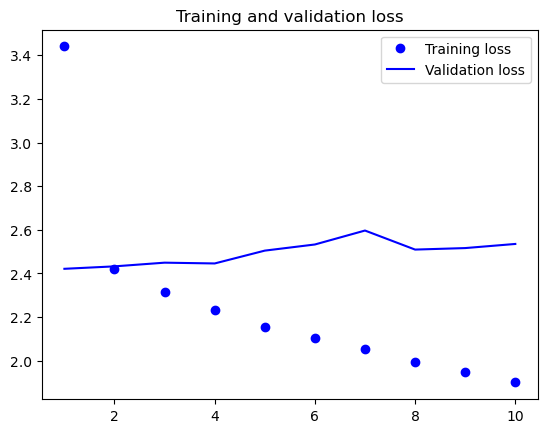

In [88]:
import matplotlib.pyplot as plt

loss = history.history['mae']
val_loss = history.history['val_mae']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# [과제 3] RNN 기반 모델 시도하기(스태킹)

# [과제 4] 규제(dropout) 적용한 LSTM 모델 훈련 및 평가하기

# [과제 5] dropout 규제와 스태킹을 적용한 GPU 모델 훈련 및 평가하기

In [24]:
# 예시) x = layers.GPU(units=32, recurrent_dropout=0.5, return_sequences=True)(inputs)